Define API Model 

In [4]:
from inference_sdk import InferenceHTTPClient

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="Lijr1DMPITvuVGF8fyvB"
)

# result = CLIENT.infer(your_image.jpg, model_id="football-players-detection-3zvbc/12")

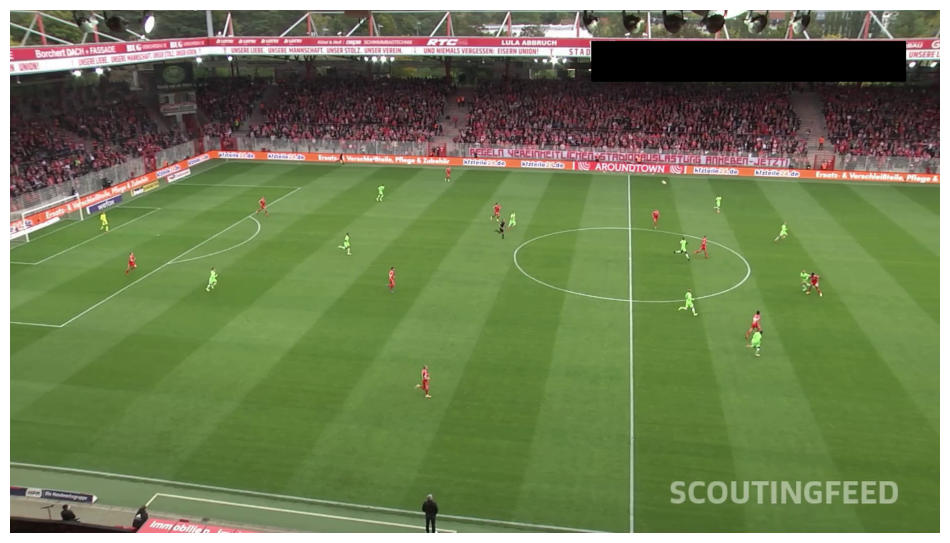

In [5]:
import supervision as sv

SOURCE_VIDEO_PATH = r"D:\DLS\121364_0.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

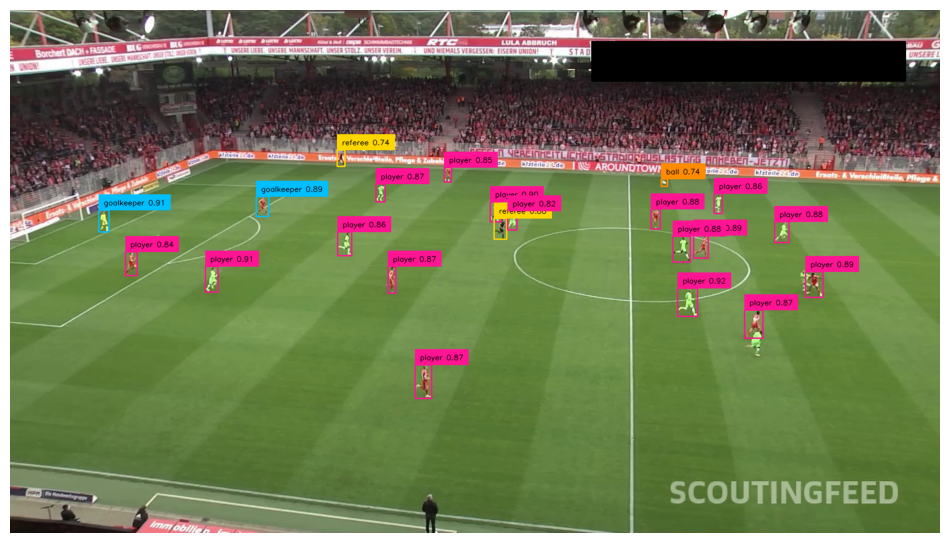

In [6]:

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = CLIENT.infer(frame, model_id="football-players-detection-3zvbc/12")
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

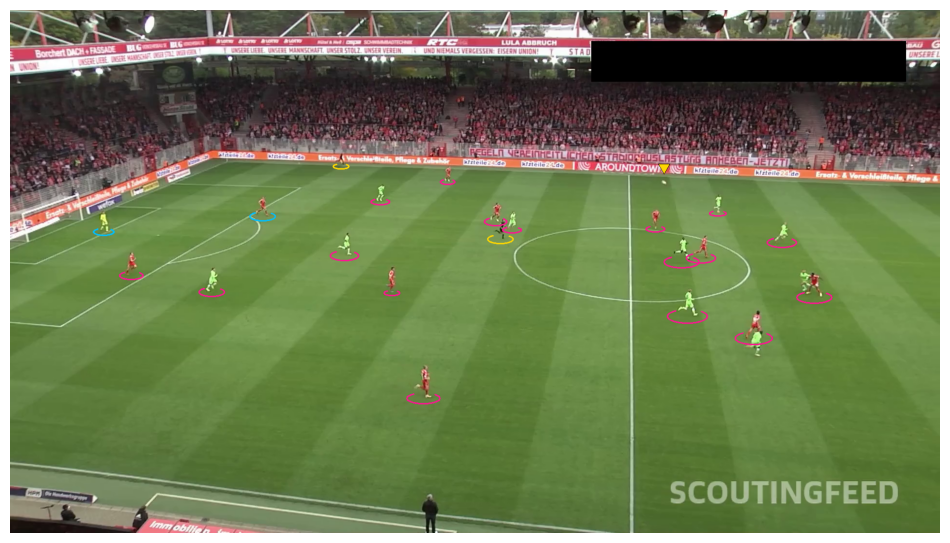

In [7]:
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = CLIENT.infer(frame,model_id="football-players-detection-3zvbc/12")
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

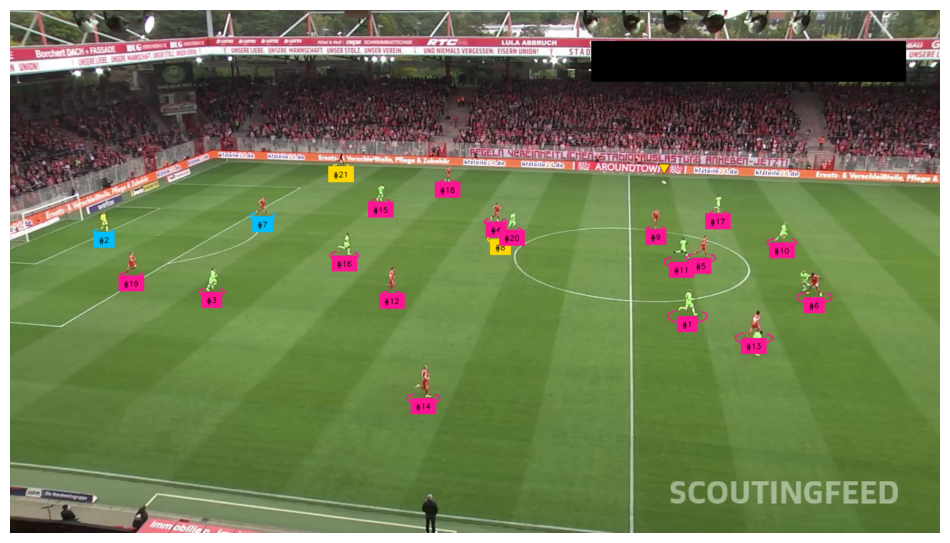

In [6]:
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = CLIENT.infer(frame, model_id="football-players-detection-3zvbc/12")
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

In [8]:
from tqdm import tqdm
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = CLIENT.infer(frame, model_id="football-players-detection-3zvbc/12")
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 25it [04:23, 10.53s/it]


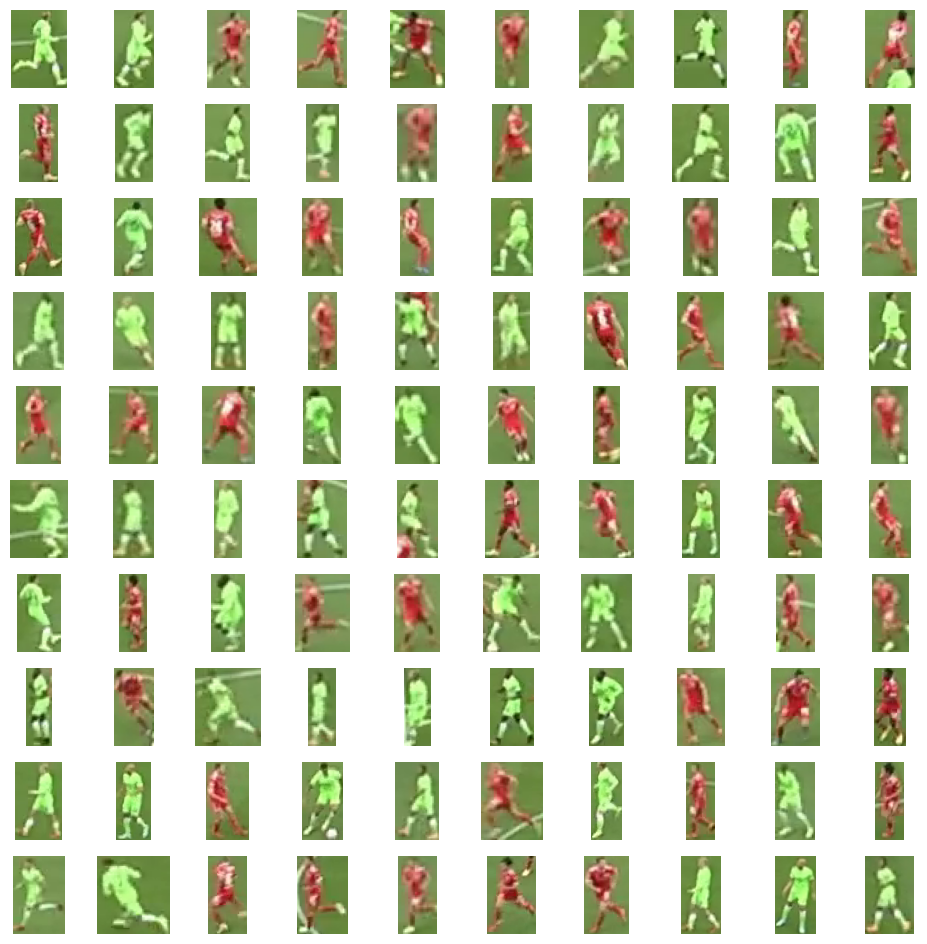

In [9]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

In [10]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

In [11]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32

crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 15it [08:53, 35.57s/it]


In [12]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [13]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [15]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = CLIENT.infer(frame,model_id="football-players-detection-3zvbc/12")
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier()
team_classifier.fit(crops)

collecting crops: 25it [04:01,  9.65s/it]
Embedding extraction: 18it [10:00, 33.34s/it]


In [16]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

In [17]:

RESULT_VIDEO_PATH = r"D:\DLS\RESULT.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()
video_info=sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink=sv.VideoSink(RESULT_VIDEO_PATH, video_info)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
with video_sink:
  for frame in tqdm(frame_generator,total=video_info.total_frames):
    result = CLIENT.infer(frame, model_id="football-players-detection-3zvbc/12")
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    all_detections = detections[detections.class_id != BALL_ID]
    all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
    all_detections = tracker.update_with_detections(detections=all_detections)

    goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
    players_detections = all_detections[all_detections.class_id == PLAYER_ID]
    referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

    players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
    players_detections.class_id = team_classifier.predict(players_crops)

    goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
        players_detections, goalkeepers_detections)

    referees_detections.class_id -= 1

    all_detections = sv.Detections.merge([
        players_detections, goalkeepers_detections, referees_detections])

    labels = [
        f"#{tracker_id}"
        for tracker_id
        in all_detections.tracker_id
    ]

    all_detections.class_id = all_detections.class_id.astype(int)

    annotated_frame = frame.copy()
    annotated_frame = ellipse_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame,
        detections=all_detections,
        labels=labels)
    annotated_frame = triangle_annotator.annotate(
        scene=annotated_frame,
        detections=ball_detections)
    video_sink.write_frame(annotated_frame)



  0%|                                                                                          | 0/750 [00:00<?, ?it/s]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:19, 19.27s/it]
  0%|                                                                               | 1/750 [00:48<10:06:53, 48.62s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:22, 22.25s/it]
  0%|▏                                                                               | 2/750 [01:29<9:10:18, 44.14s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:18, 18.41s/it]
  0%|▎                                                                               | 3/750 [02:06<8:27:56, 40.80s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extraction: 1it [00:22, 22.01s/it]
  1%|▍                                                                               | 4/750 [02:44<8:15:15, 39.83s/it]
Embedding extraction: 0it [00:00, ?it/s]
Embedding extra

KeyboardInterrupt: 